In [5]:
# Importación de las librerías necesarias
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import classification_report

In [6]:
# Definimos el tamaño de las imágenes (32x32 píxeles)
IMG_SIZE = 32

# Función para cargar el dataset UTKFace
def load_utkface_data(dataset_path):
    images = []
    labels = []
    
    for filename in os.listdir(dataset_path):
        if filename.endswith(".jpg"):
            parts = filename.split('_')
            # Validar formato del nombre del archivo
            if len(parts) != 4:
                print(f"Archivo con formato no válido ignorado: {filename}")
                continue
            
            label = int(parts[2])  # [age]_[gender]_[race]_[date&time].jpg
            
            img = cv2.imread(os.path.join(dataset_path, filename))
            if img is None:
                print(f"Error al cargar la imagen: {filename}")
                continue
            
            img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
            images.append(img)
            labels.append(label)

    return np.array(images), np.array(labels)

# Ruta donde se encuentra el dataset
dataset_path = "./UTKFace"

# Carga de los datos
images, labels = load_utkface_data(dataset_path)

Archivo con formato no válido ignorado: 39_1_20170116174525125.jpg.chip.jpg
Archivo con formato no válido ignorado: 61_1_20170109142408075.jpg.chip.jpg
Archivo con formato no válido ignorado: 61_1_20170109150557335.jpg.chip.jpg


In [7]:
# Normalización de imágenes entre 0 y 1
images = images / 255.0

# Convertir etiquetas a formato categórico
labels = to_categorical(labels, num_classes=5)

# División del dataset en entrenamiento y prueba (80% - 20%)
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)

In [8]:
# Definición de la arquitectura CNN
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 3)),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(5, activation='softmax')
])

# Compilación del modelo
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Resumen del modelo
model.summary()

c:\Users\jcrod\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 30, 30, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 15, 15, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 13, 13, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 4, 4, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 2, 2, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 159,557 (623.27 KB)

 Trainable params: 159,557 (623.27 KB)

 Non-trainable params: 0 (0.00 B)

In [9]:
# Definición de callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6, verbose=1)

# Entrenamiento del modelo
history = model.fit(
    X_train,
    y_train,
    epochs=10,
    validation_split=0.2,
    batch_size=64,
    callbacks=[early_stop, reduce_lr]
)

Epoch 1/10
237/237 ━━━━━━━━━━━━━━━━━━━━ 8s 23ms/step - accuracy: 0.4313 - loss: 1.4349 - val_accuracy: 0.5425 - val_loss: 1.1670 - learning_rate: 0.0010
Epoch 2/10
237/237 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - accuracy: 0.5708 - loss: 1.1547 - val_accuracy: 0.6963 - val_loss: 0.8687 - learning_rate: 0.0010
Epoch 3/10
237/237 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - accuracy: 0.6786 - loss: 0.8941 - val_accuracy: 0.7401 - val_loss: 0.7528 - learning_rate: 0.0010
Epoch 4/10
237/237 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - accuracy: 0.7155 - loss: 0.8141 - val_accuracy: 0.7551 - val_loss: 0.7103 - learning_rate: 0.0010
Epoch 5/10
237/237 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - accuracy: 0.7361 - loss: 0.7470 - val_accuracy: 0.7596 - val_loss: 0.7144 - learning_rate: 0.0010
Epoch 6/10
237/237 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - accuracy: 0.7585 - loss: 0.7057 - val_accuracy: 0.7749 - val_loss: 0.6703 - learning_rate: 0.0010
Epoch 7/10
237/237 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - accuracy: 0.7750 - loss: 0.

149/149 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.7586 - loss: 0.6988
Test accuracy: 0.7638244032859802


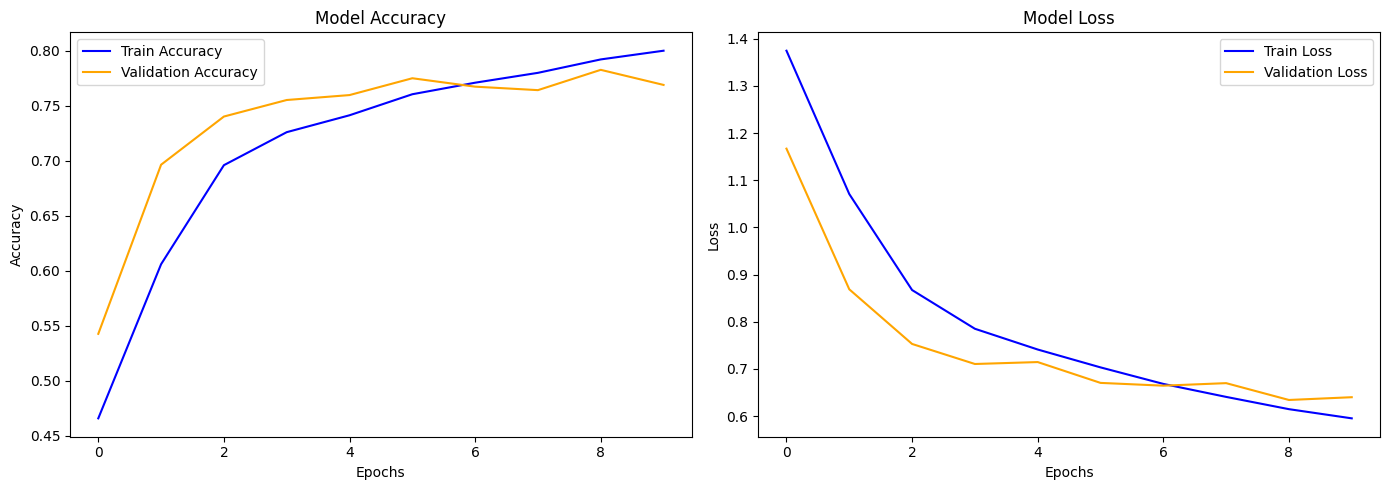

In [13]:
# Evaluación en el conjunto de prueba
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test accuracy: {test_acc}")

# Gráfica de la precisión y pérdida durante el entrenamiento
plt.figure(figsize=(14, 5))

# Precisión
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy', color='blue')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='orange')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Pérdida
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()  # Mejora el ajuste entre subgráficas
plt.show()

149/149 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
              precision    recall  f1-score   support

       White       0.78      0.88      0.82      1954
       Black       0.75      0.86      0.80       901
       Asian       0.84      0.76      0.80       708
      Indian       0.69      0.69      0.69       834
      Others       0.62      0.04      0.07       341

    accuracy                           0.76      4738
   macro avg       0.74      0.65      0.64      4738
weighted avg       0.75      0.76      0.74      4738



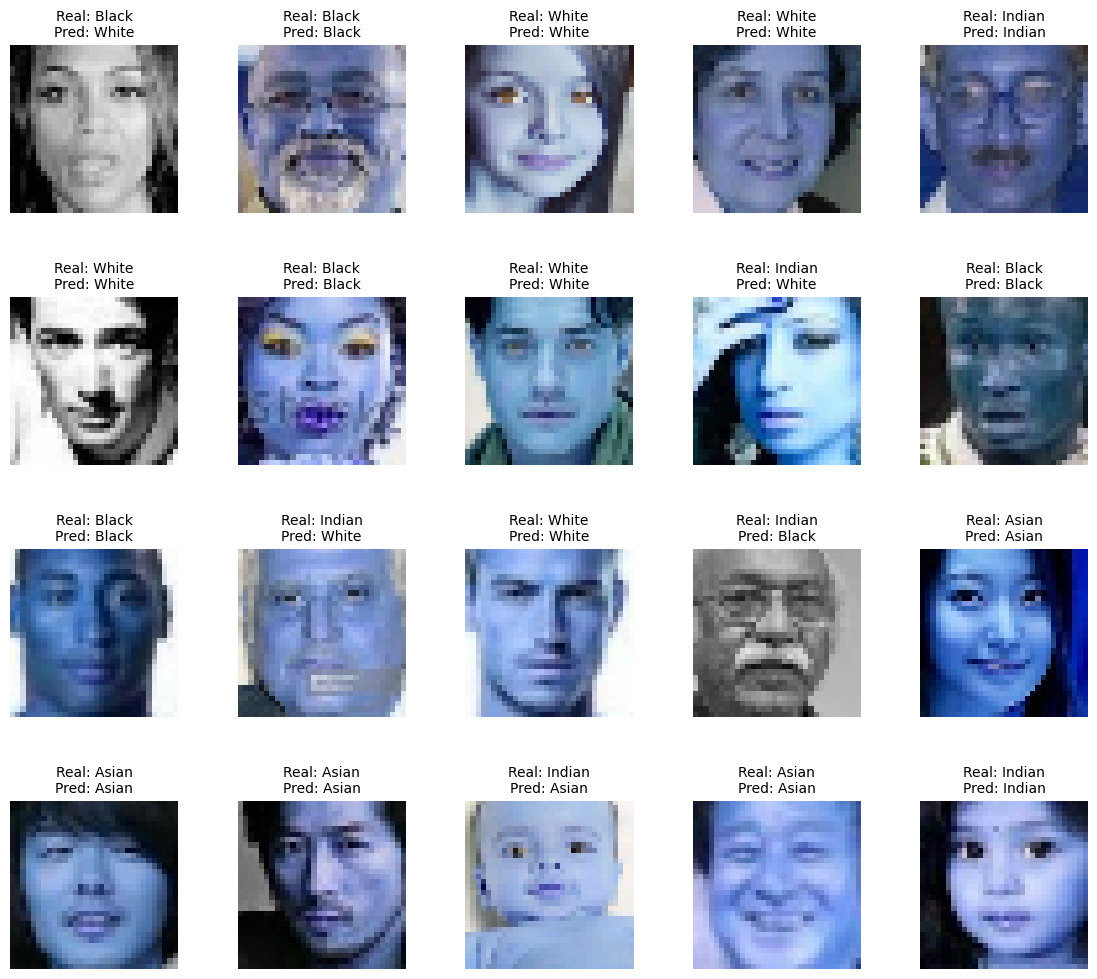

In [11]:
# Predicción en el conjunto de prueba
y_pred = np.argmax(model.predict(X_test), axis=-1)
y_true = np.argmax(y_test, axis=-1)

# Reporte de clasificación
target_names = ['White', 'Black', 'Asian', 'Indian', 'Others']
print(classification_report(y_true, y_pred, target_names=target_names))

# Visualización de 20 ejemplos con las predicciones del modelo
indices = np.random.choice(len(X_test), 20, replace=False)
fig, axes = plt.subplots(4, 5, figsize=(14, 12))

for i, ax in enumerate(axes.flat):
    img = X_test[indices[i]]
    ax.imshow(img)
    true_label = target_names[y_true[indices[i]]]
    pred_label = target_names[y_pred[indices[i]]]
    ax.set_title(f"Real: {true_label}\nPred: {pred_label}", fontsize=10)
    ax.axis('off')

plt.subplots_adjust(hspace=0.5, wspace=0.3)
plt.show()